In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from qiskit.circuit.library import EfficientSU2, PauliFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.primitives import Sampler
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.circuit.library import QNNCircuit
import time

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [15]:
# load data
original_features = np.loadtxt('fault.txt')
labels  = np.loadtxt('faultlabel.txt')

In [16]:
features = original_features[:, [0,5,6]]

In [17]:
scaler_x = MinMaxScaler()
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

f_train = scaler_x.fit_transform(X_train)
f_test = scaler_x.transform(X_test)

In [18]:
print('f_train shape: ', f_train.shape)
print('f_test shape: ', f_test.shape)

f_train shape:  (6869, 3)
f_test shape:  (1718, 3)


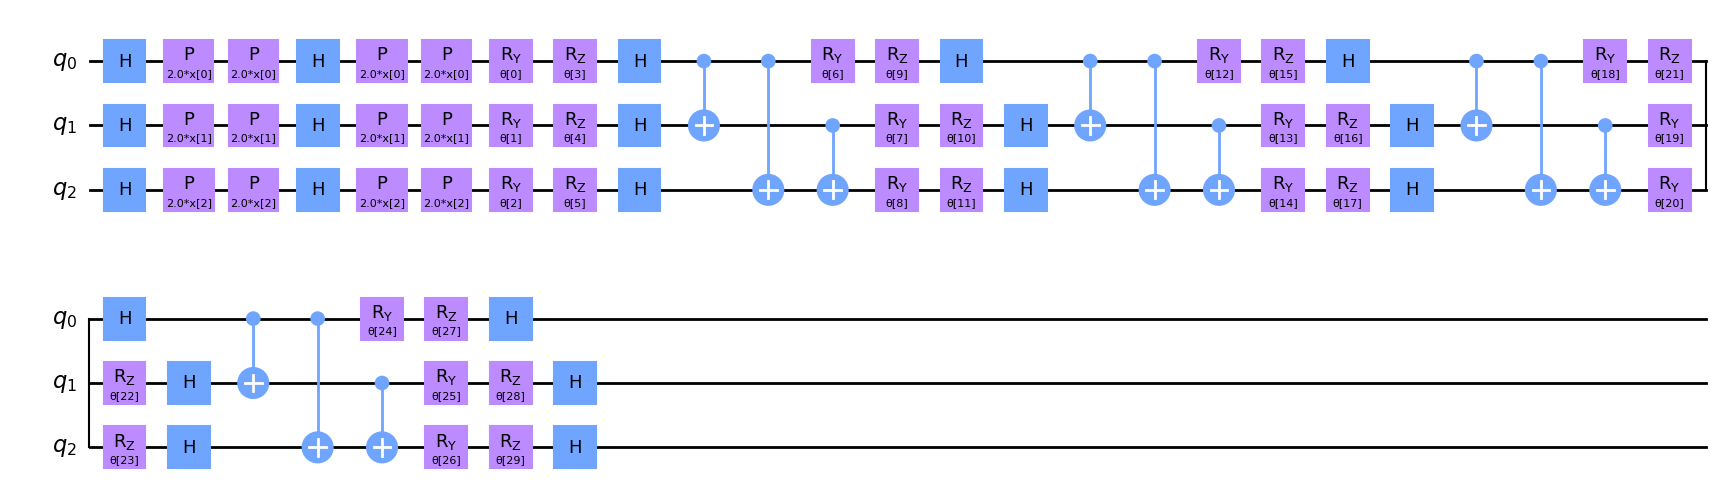

In [19]:
num_q = f_train.shape[1]
#fm = ZZFeatureMap(num_qubits, reps=2, entanglement='full')
fm = PauliFeatureMap(num_q, reps=2, paulis=['Z','H'])
ansatz = EfficientSU2(num_q, reps=4, entanglement='full', su2_gates=['ry','rz','h'])

# create quantum circuit
qc = QNNCircuit(
    num_qubits=num_q,
    feature_map=fm,
    ansatz=ansatz
)

# visualize quantum circuit
qc.decompose().draw('mpl', style='clifford')

In [20]:
def interpret(bitstring):
    return int(bitstring) % 2

sampler = Sampler()

In [21]:
# Qiskit quantum neural network
qnn = SamplerQNN(
    circuit = qc,
    input_params = fm.parameters,
    weight_params = ansatz.parameters,
    output_shape = 2,
    interpret = interpret,
    sampler=sampler
)

In [22]:
# Create a PyTorch model using TorchConnector
model = TorchConnector(qnn)
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Convert training data to PyTorch tensors
X_train_tensor = torch.tensor(f_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
batch_size = 7
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
epochs = 15
for epoch in range(epochs):
    start_time = time.time()  # Record the start time
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = F.mse_loss(output, y_batch)
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    end_time = time.time()  # Record the end time
    epoch_duration = (end_time - start_time) / 60  # time in minutes
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader)}, Time: {epoch_duration:.2f} minutes')


Epoch 1/15, Loss: 0.17471930447609266, Time: 9.27 minutes
Epoch 2/15, Loss: 0.15581836373888547, Time: 9.29 minutes
Epoch 3/15, Loss: 0.1498627451356584, Time: 9.29 minutes
Epoch 4/15, Loss: 0.14642294397664896, Time: 9.30 minutes
Epoch 5/15, Loss: 0.14426983703997615, Time: 9.29 minutes
Epoch 6/15, Loss: 0.14326145680139482, Time: 9.29 minutes
Epoch 7/15, Loss: 0.14269390188976971, Time: 9.23 minutes
Epoch 8/15, Loss: 0.14234054434566537, Time: 9.17 minutes
Epoch 9/15, Loss: 0.1421505740052753, Time: 9.22 minutes
Epoch 10/15, Loss: 0.14206954303468802, Time: 9.28 minutes
Epoch 11/15, Loss: 0.1419639032174759, Time: 9.28 minutes
Epoch 12/15, Loss: 0.1417912992624122, Time: 9.28 minutes
Epoch 13/15, Loss: 0.14172159249148883, Time: 9.28 minutes
Epoch 14/15, Loss: 0.14161982331538758, Time: 9.28 minutes
Epoch 15/15, Loss: 0.1415185294855697, Time: 9.25 minutes


In [23]:
# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(f_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [24]:
# Evaluate the model
model.eval()
with torch.no_grad():
    output = model(X_test_tensor)
    test_loss = F.mse_loss(output, y_test_tensor)
    predictions = torch.argmax(output, dim=1)
    actual = torch.argmax(y_test_tensor, dim=1)
    accuracy = (predictions == actual).float().mean()

In [25]:
print(f'Test set loss: {test_loss.item()}')
print(f'Test set accuracy: {accuracy.item() * 100:.2f}%')

Test set loss: 0.14556795358657837
Test set accuracy: 85.22%


Confusion Matrix
[[742 123]
 [131 722]]


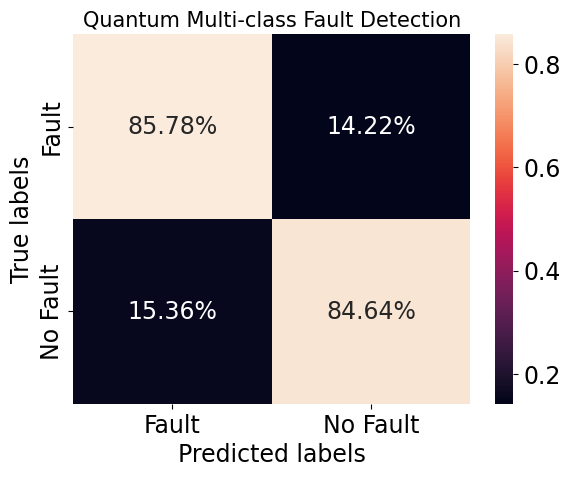

In [30]:
# Confusion Matrix and Heatmap
cm = confusion_matrix(actual, predictions)

l = ['Fault', 'No Fault']
column = [f'{label}' for label in l]
indices = [f'{label}' for label in l]
table = pd.DataFrame(cm, columns=column, index=indices)

print("Confusion Matrix")
print(cm)

# Normalize by row (truth labels)
table_normalized = table.div(table.sum(axis=1), axis=0)

# Plotting the heatmap
color = None
sns.heatmap(table_normalized, annot=True, fmt='.2%', cmap=color)
plt.title("Quantum Multi-class Fault Detection", fontsize=15)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.rcParams.update({'font.size': 17})
plt.show()